# Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2  
%autosave 10

Autosaving every 10 seconds


In [2]:
import torch, torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
from PIL import Image
import random, os, sys, argparse
from pathlib import Path
from tqdm import tqdm
import pickle

from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import shap

In [3]:
sys.path.insert(0,'/xxx/home/xxx/xxx/xxx/projects/shortcut_detection_and_mitigation/experiments/toy_expts/')
from models import *

# User Hyperparams

In [51]:
'''
vgg16_kmnist_27437
vgg16_kmnist_patch_48316
vgg16_mnist_75872
vgg16_mnist_patch_42954
vgg16_cifar10_29954
'''

'\nvgg16_kmnist_27437\nvgg16_kmnist_patch_48316\nvgg16_mnist_75872\nvgg16_mnist_patch_42954\nvgg16_cifar10_29954\n'

In [52]:
model = 'resnet18' # resnet18, vgg16, densenet121
dataset = 'svhn' # mnist,kmnist
add_patch_flag = False
num_classes = 10   
data_csv = None
expt_name = f'resnet18_svhn_{int(random.random()*100000)}'
save_dir = '/xxx/home/xxx/xxx/xxx/projects/shortcut_detection_and_mitigation/experiments/toy_expts/output/'

num_epochs = 10
lr = 0.1
seed = 0
num_ch = 1 # num of channels in image
num_embs = 2000 # 1500 for mnist, 10k for cifar10
K = 29 # K neighbours
num_test_imgs = 100 # num of test images for plotting PD
lp_norm = 1 # for computing KNN
knn_pos_thresh = 0.5
knn_neg_thresh = 0.5

# Util Functions

In [53]:
# takes in a list of img paths and plots grid of images
def plot_images(img_list, rows, cols, titles=None):
    plt.figure(figsize=(7.5*cols,7.5*rows))
    for i in range(rows*cols):
        plt.subplot(rows,cols,i+1)
        if type(img_list[0])==str:
            img = plt.imread(img_list[i])
        else:
            img = img_list[i]
        plt.imshow(img)
        if titles is not None:
            plt.title(titles[i])
    plt.show()

# Load Dataset

In [54]:
# Setting the seed
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [57]:
# datasets
print('==> Preparing data..')
if dataset=='mnist':
    # transformations
    trans = torchvision.transforms.Compose([
                torchvision.transforms.Resize((32,32)),
                torchvision.transforms.ToTensor(),
#                 torchvision.transforms.Lambda(lambda x: x.repeat(3,1,1))
            ])  # for mnist and fmnist we replicate channels

    root_dir = '/xxx/home/xxx/xxx/xxx/projects/shortcut_detection_and_mitigation/data/'
    trainset = torchvision.datasets.MNIST(root_dir, transform=trans, download=True)
    testset = torchvision.datasets.MNIST(root_dir, train=False, transform=trans, download=True)
    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=500, shuffle=False, num_workers=2)
elif dataset=='fmnist':
    # transformations
    trans = torchvision.transforms.Compose([
                torchvision.transforms.Resize((32,32)),
                torchvision.transforms.ToTensor(),
#                 torchvision.transforms.Lambda(lambda x: x.repeat(3,1,1))
            ])  # for mnist and fmnist we replicate channels

    root_dir = '/xxx/home/xxx/xxx/xxx/projects/shortcut_detection_and_mitigation/data/'
    trainset = torchvision.datasets.FashionMNIST(root_dir, transform=trans, download=True)
    testset = torchvision.datasets.FashionMNIST(root_dir, train=False, transform=trans, download=True)
    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=500, shuffle=False, num_workers=2)
elif dataset=='kmnist':
    # transformations
    trans = torchvision.transforms.Compose([
                torchvision.transforms.Resize((32,32)),
                torchvision.transforms.ToTensor(),
#                 torchvision.transforms.Lambda(lambda x: x.repeat(3,1,1))
            ])  # for mnist and fmnist we replicate channels

    root_dir = '/xxx/home/xxx/xxx/xxx/projects/shortcut_detection_and_mitigation/data/'
    trainset = torchvision.datasets.KMNIST(root_dir, transform=trans, download=True)
    testset = torchvision.datasets.KMNIST(root_dir, train=False, transform=trans, download=True)
    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=500, shuffle=False, num_workers=2)
elif dataset=='svhn':
    # transformations
    trans = torchvision.transforms.Compose([
                torchvision.transforms.Resize((32,32)),
#                 torchvision.transforms.Grayscale(num_output_channels=1),
                torchvision.transforms.ToTensor(),
            ])  # for mnist and fmnist we replicate channels

    root_dir = '/xxx/home/xxx/xxx/xxx/projects/shortcut_detection_and_mitigation/data/svhn_gray/'
    trainset = torchvision.datasets.SVHN(root_dir, split='train', transform=trans, download=True)
    testset = torchvision.datasets.SVHN(root_dir, split='test', transform=trans, download=True)
    
    trainset.targets = trainset.labels
    testset.targets = testset.labels
    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=500, shuffle=False, num_workers=2)
elif dataset=='cifar10':
    # transformations
    trans = torchvision.transforms.Compose([
                torchvision.transforms.Resize((32,32)),
#                 torchvision.transforms.Grayscale(num_output_channels=1),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean=[0.4914,0.4822,0.4465],std=[0.2470,0.2435,0.2616])
            ])  # for mnist and fmnist we replicate channels

    root_dir = '/xxx/home/xxx/xxx/xxx/projects/shortcut_detection_and_mitigation/data/'
    trainset = torchvision.datasets.CIFAR10(root_dir, transform=trans, download=True)
    testset = torchvision.datasets.CIFAR10(root_dir, train=False, transform=trans, download=True)
    
#     # use only 2 classes
#     arr = (np.array(trainset.targets)==0) | (np.array(trainset.targets)==1)
#     trainset.data = trainset.data[arr]
#     trainset.targets = np.array(trainset.targets)[arr]
    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=500, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=500, shuffle=False, num_workers=2)

==> Preparing data..


  0%|          | 0/182040794 [00:00<?, ?it/s]

  0%|          | 0/64275384 [00:00<?, ?it/s]

In [61]:
dir(trainset.data)

['T',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_finalize__',
 '__array_function__',
 '__array_interface__',
 '__array_prepare__',
 '__array_priority__',
 '__array_struct__',
 '__array_ufunc__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__complex__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__ilshift__',
 '__imatmul__',
 '__imod__',
 '__imul__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__irshift__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lshift__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdivmod__',
 '__

In [36]:
# for batch_idx, (inputs, targets) in enumerate(tqdm(trainloader)):
#     break
    

In [37]:
# add patch shortcut
def add_patch(img,lab):
    mid = img.shape[0]//2
    mid_x = mid-2
    mid_y = mid+3    
    if lab==0:
        img[:4,:4] = 255
    elif lab==1:
        img[:4,-4:] = 255
    elif lab==2:
        img[-4:,:4] = 255
    elif lab==3:
        img[-4:,-4:] = 255
    elif lab==4:
        img[mid_x:mid_y,mid_x:mid_y] = 255
    elif lab==5: 
        img[:4,12:16] = 255
    elif lab==6:  
        img[-4:,12:16] = 255
    elif lab==7:
        img[12:16,:4] = 255
    elif lab==8:    
        img[12:16,-4:] = 255        
    return img

if add_patch_flag:    
    for (img,lab) in zip(trainset.data,trainset.targets):
        img = add_patch(img,lab)        
    for (img,lab) in zip(testset.data,testset.targets):
        img = add_patch(img,lab)

# GradCam Viz

In [ ]:
# # SHAP on intermediate soft-KNN outputs
# # user hyperparams
# expt_name = 'vgg16_kmnist_patch_48316'
# layer_id = 3 # vgg layer to viz net.module.features[layer_id]
#                # 0,3,7,10,14,17,20,24,27,30,34,37,40
# train_emb_idx = 1 # info_dict['feats'][train_emb_idx]
#               # 0,1,2,3,4,5,6,7,8,9,10,11,12

# # load model
# train_embs_pkl_path = os.path.join(save_dir,f'{expt_name}.pkl')
# net = nn.DataParallel(customVGG2('VGG16', train_embs_pkl_path, layer_id, train_emb_idx, num_channels=1))
# net.load_state_dict(torch.load(os.path.join(save_dir,f'{expt_name}.pt'))['net'])
# net.eval()

# # load batch of images
# batch = next(iter(testloader))
# images, _ = batch

# # prepare shap train and test images
# shap_train_imgs = images[:50].to('cuda')
# shap_test_imgs = images[490:].to('cuda')

# e = shap.DeepExplainer(net, shap_train_imgs)
# shap_values = e.shap_values(shap_test_imgs)

# shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
# test_numpy = np.swapaxes(np.swapaxes(shap_test_imgs.cpu().numpy(), 1, -1), 1, 2)
# shap.image_plot(shap_numpy, -test_numpy, width=100.0)

In [ ]:
# GradCAM on intermediate soft-KNN outputs
# user hyperparams
expt_name = 'vgg16_kmnist_patch_84442'
layer_id = 0 # vgg layer to viz net.module.features[layer_id]
               # 0,3,7,10,14,17,20,24,27,30,34,37,40
train_emb_idx = 0 # info_dict['feats'][train_emb_idx]
              # 0,1,2,3,4,5,6,7,8,9,10,11,12

# load model
train_embs_pkl_path = os.path.join(save_dir,f'{expt_name}.pkl')
net = nn.DataParallel(customVGG2('VGG16', train_embs_pkl_path, layer_id, train_emb_idx, num_channels=1))
net.load_state_dict(torch.load(os.path.join(save_dir,f'{expt_name}.pt'))['net'])
net.eval()

# loop over test images
for _ in range(25):
    img_id = int(random.random()*len(trainset.data))
    img = trainset.data[img_id]
    
    # pre-process the img to make it compatible for forward pass
    to_pil_trans = transforms.ToPILImage()
    if dataset=='mnist' or dataset=='kmnist' or dataset=='fmnist':
        img_tensor = to_pil_trans(img.squeeze().to('cuda'))
    else:
        img_tensor = to_pil_trans(img.permute(2,0,1).to('cuda'))
    img_tensor = trans(img_tensor).unsqueeze(0)
    if img_tensor.shape[1]==4:
        img_tensor = img_tensor[:,0,:,:].unsqueeze(0)
        
    img_rgb = img_tensor.squeeze().unsqueeze(-1).expand(32,32,3)

    # gradCAM code
    targets = [ClassifierOutputTarget(0)]
    target_layers = [net.module.features[layer_id]]

    cam = GradCAM(model=net, target_layers=target_layers, use_cuda=True)
    grayscale_cams = cam(input_tensor=img_tensor, targets=targets, aug_smooth=False, eigen_smooth=False)
    cam_op = show_cam_on_image(np.array(img_rgb)*0.35, (grayscale_cams[0]>0.8).astype(float)*20, use_rgb=True)
    
    img_list = []
    img_list.append(img_rgb)
    img_list.append(grayscale_cams[0])
    img_list.append((grayscale_cams[0]>0.8).astype(float))
    img_list.append(cam_op)

    # plot results
    plot_images(img_list,rows=1,cols=4,titles=[f'Img Id: {img_id}','Heatmap','Thresholded Heatmap','Overlay'])

In [ ]:
cam_op.shape, img_rgb.shape, grayscale_cams[0].shape

### Save Figs to Folder

In [ ]:
img_id = 45456# 45456 , 50547
img = trainset.data[img_id]

# pre-process the img to make it compatible for forward pass
to_pil_trans = transforms.ToPILImage()
if dataset=='mnist' or dataset=='kmnist' or dataset=='fmnist':
    img_tensor = to_pil_trans(img.squeeze().to('cuda'))
else:
    img_tensor = to_pil_trans(img.permute(2,0,1).to('cuda'))
img_tensor = trans(img_tensor).unsqueeze(0)
if img_tensor.shape[1]==4:
    img_tensor = img_tensor[:,0,:,:].unsqueeze(0)

img_rgb = img_tensor.squeeze().unsqueeze(-1).expand(32,32,3)

# gradCAM code
targets = [ClassifierOutputTarget(0)]
target_layers = [net.module.features[layer_id]]

cam = GradCAM(model=net, target_layers=target_layers, use_cuda=True)
grayscale_cams = cam(input_tensor=img_tensor, targets=targets, aug_smooth=False, eigen_smooth=False)
cam_op = show_cam_on_image(np.array(img_rgb)*0.35, (grayscale_cams[0]>0.8).astype(float)*20, use_rgb=True)

img_list = []
img_list.append(img_rgb)
img_list.append(grayscale_cams[0])
img_list.append((grayscale_cams[0]>0.8).astype(float))
img_list.append(cam_op)

# plot results
plot_images(img_list,rows=1,cols=4,titles=['Original Img','Heatmap','Thresholded Heatmap','Overlay'])

In [ ]:
plt.axis('off') 
plt.imshow(cam_op)
plt.imsave('/xxx/home/xxx/xxx/xxx/projects/shortcut_detection_and_mitigation/experiments/paper_quality_plots/results/kmnist_patch_2b.svg',cam_op)

In [ ]:
plt.axis('off') 
plt.imshow(img_rgb)
plt.imsave('/xxx/home/xxx/xxx/xxx/projects/shortcut_detection_and_mitigation/experiments/paper_quality_plots/results/kmnist_patch_2a.svg',img_rgb)

# Train Model

In [38]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy


# Model
print('==> Building model..')
if model=='resnet18':
    # net = VGG('VGG19')
    net = ResNet18(num_channels=num_ch)
    # net = PreActResNet18()
    # net = GoogLeNet()
    # net = DenseNet121()
    # net = ResNeXt29_2x64d()
    # net = MobileNet()
    # net = MobileNetV2()
    # net = DPN92()
    # net = ShuffleNetG2()
    # net = SENet18()
    # net = ShuffleNetV2(1)
    # net = EfficientNetB0()
    # net = RegNetX_200MF()
    # net = SimpleDLA()
elif model=='vgg16':
    net = VGG('VGG16',num_channels=num_ch)
elif model=='densenet121':
    net = DenseNet121()
net = net.to(device)
    
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(tqdm(trainloader)):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                 % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))


def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(testloader)):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    print(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                 % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
#         if not os.path.isdir(f'{args['expt_name']}_checkpoint'):
#             os.mkdir('checkpoint')
        torch.save(state, os.path.join(save_dir,f'{expt_name}.pt'))
        best_acc = acc


for epoch in range(num_epochs):
    train(epoch)
    test(epoch)
    scheduler.step()

==> Building model..

Epoch: 0


100%|██████████| 573/573 [00:33<00:00, 16.91it/s]


572 573 Loss: 1.709 | Acc: 41.378% (30312/73257)


100%|██████████| 53/53 [00:03<00:00, 16.77it/s]


52 53 Loss: 0.895 | Acc: 72.968% (18995/26032)
Saving..

Epoch: 1


100%|██████████| 573/573 [00:33<00:00, 16.89it/s]


572 573 Loss: 0.431 | Acc: 86.713% (63523/73257)


100%|██████████| 53/53 [00:03<00:00, 16.90it/s]


52 53 Loss: 0.342 | Acc: 89.513% (23302/26032)
Saving..

Epoch: 2


100%|██████████| 573/573 [00:34<00:00, 16.82it/s]


572 573 Loss: 0.277 | Acc: 91.650% (67140/73257)


100%|██████████| 53/53 [00:03<00:00, 16.83it/s]


52 53 Loss: 0.296 | Acc: 91.126% (23722/26032)
Saving..

Epoch: 3


  7%|▋         | 40/573 [00:02<00:35, 15.01it/s]


KeyboardInterrupt: 

# Obtain Train (subset) embeddings

In [39]:
# load checkpoint
# expt_name = 'vgg16_cifar10_29954'
if model=='resnet18':
    net = nn.DataParallel(ResNet18(num_channels=num_ch))
elif model=='vgg16':
    net = nn.DataParallel(VGG('VGG16',num_channels=num_ch))
net.load_state_dict(torch.load(os.path.join(save_dir,f'{expt_name}.pt'))['net'])
net.eval()

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       

In [40]:
# adding hook function for resnet18
# def add_resnet18_hooks(net, hook):
#     net.module.bn1.register_forward_hook(hook)
    
#     net.module.layer1[0].bn1.register_forward_hook(hook)
#     net.module.layer1[0].shortcut.register_forward_hook(hook)
    
#     net.module.layer1[1].bn1.register_forward_hook(hook)
#     net.module.layer1[1].shortcut.register_forward_hook(hook)

#     net.module.layer2[0].bn1.register_forward_hook(hook)
#     net.module.layer2[0].shortcut.register_forward_hook(hook)
    
#     net.module.layer2[1].bn1.register_forward_hook(hook)
#     net.module.layer2[1].shortcut.register_forward_hook(hook)
    
#     net.module.layer3[0].bn1.register_forward_hook(hook)
#     net.module.layer3[0].shortcut.register_forward_hook(hook)
    
#     net.module.layer3[1].bn1.register_forward_hook(hook)
#     net.module.layer3[1].shortcut.register_forward_hook(hook)
    
#     net.module.layer4[0].bn1.register_forward_hook(hook)
#     net.module.layer4[0].shortcut.register_forward_hook(hook)
    
#     net.module.layer4[1].bn1.register_forward_hook(hook)
#     net.module.layer4[1].shortcut.register_forward_hook(hook)
        
#     return net

def add_resnet18_hooks(net, hook):
    net.module.bn1.register_forward_hook(hook)
    
    net.module.layer1[0].conv1.register_forward_hook(hook)
    net.module.layer1[0].conv2.register_forward_hook(hook)
    
    net.module.layer1[1].conv1.register_forward_hook(hook)
    net.module.layer1[1].conv2.register_forward_hook(hook)

    net.module.layer2[0].conv1.register_forward_hook(hook)
    net.module.layer2[0].conv2.register_forward_hook(hook)
    
    net.module.layer2[1].conv1.register_forward_hook(hook)
    net.module.layer2[1].conv2.register_forward_hook(hook)
    
    net.module.layer3[0].conv1.register_forward_hook(hook)
    net.module.layer3[0].conv2.register_forward_hook(hook)
    
    net.module.layer3[1].conv1.register_forward_hook(hook)
    net.module.layer3[1].conv2.register_forward_hook(hook)
    
    net.module.layer4[0].conv1.register_forward_hook(hook)
    net.module.layer4[0].conv2.register_forward_hook(hook)
    
    net.module.layer4[1].conv1.register_forward_hook(hook)
    net.module.layer4[1].conv2.register_forward_hook(hook)
        
    return net

def add_vgg16_hooks(net, hook):
    net.module.features[0].register_forward_hook(hook)
    net.module.features[3].register_forward_hook(hook)
    net.module.features[7].register_forward_hook(hook)
    net.module.features[10].register_forward_hook(hook)
    net.module.features[14].register_forward_hook(hook)
    net.module.features[17].register_forward_hook(hook)
    net.module.features[20].register_forward_hook(hook)
    net.module.features[24].register_forward_hook(hook)
    net.module.features[27].register_forward_hook(hook)
    net.module.features[30].register_forward_hook(hook)
    net.module.features[34].register_forward_hook(hook)
    net.module.features[37].register_forward_hook(hook)
    net.module.features[40].register_forward_hook(hook)        
    return net

def add_densenet121_hooks(net, hook):
    
    for idx,layer in enumerate(net.module.dense1):
        if idx%2==0:
            layer.register_forward_hook(hook)
        
    for idx,layer in enumerate(net.module.dense2):
        if idx%2==0:
            layer.register_forward_hook(hook)
        
    for idx,layer in enumerate(net.module.dense3):
        if idx%2==0:
            layer.register_forward_hook(hook)
        
    for idx,layer in enumerate(net.module.dense4):
        if idx%2==0:
            layer.register_forward_hook(hook)
        
    return net

In [41]:
feature_maps = []  # This will be a list of Tensors, each representing a feature map
def hook_feat_map(mod, inp, out):
    out = torch.nn.functional.interpolate(out,(8,8))
#     feature_maps.append(torch.mean(out,dim=[2,3]))
    feature_maps.append(torch.reshape(out, (out.shape[0],-1)))

if model=='resnet18':
    net = add_resnet18_hooks(net, hook_feat_map)
elif model=='vgg16':
    net = add_vgg16_hooks(net, hook_feat_map)
elif model=='densenet121':
    net = add_densenet121_hooks(net, hook_feat_map)

In [42]:
def to_cpu(arr):
    for idx,x in enumerate(arr):
        arr[idx] = x.to('cpu')
    return arr

def print_memory_profile(s):
    # print GPU memory
    t = torch.cuda.get_device_properties(0).total_memory
    r = torch.cuda.memory_reserved(0)
    a = torch.cuda.memory_allocated(0)
    print(s)
    print(t/1024**3,r/1024**3,a/1024**3)
    print('\n')


In [43]:
# # something wrong here with my equal sampling I think
# if dataset=='mnist' or dataset=='kmnist' or dataset=='fmnist':
#     imgs = torch.empty((0,trainset.data[0].shape[0],trainset.data[0].shape[1]))
# else:
#     imgs = torch.empty((0,trainset.data[0].shape[0],trainset.data[0].shape[1],trainset.data[0].shape[2]))
# targs = torch.empty(0)

# for i in tqdm(range(num_classes)): 
#     cls_inds = (torch.tensor(trainset.targets)==i).nonzero(as_tuple=True)[0]

#     # randomly permute cls_inds, and subsample
#     # in total we want 3k samples of train embeddings
#     perm = torch.randperm(cls_inds.size(0))
#     inds = perm[:num_embs//num_classes]
#     cls_inds = cls_inds[inds]
#     samples = torch.tensor(trainset.data[cls_inds])
#     imgs = torch.cat((imgs,samples)) # this will have num_embs samples finally    
#     targs = torch.cat((targs,torch.ones_like(cls_inds)*i))
    
# if dataset=='mnist' or dataset=='kmnist' or dataset=='fmnist':
#     # resize again to 32x32
#     imgs_resized = torch.empty((0,32,32))
#     T = transforms.ToPILImage()
#     for img in imgs:
#         imgs_resized = torch.cat((imgs_resized,trans(T(img))))
#     train_subset = torch.utils.data.TensorDataset(imgs_resized,targs)
# else:    
#     train_subset = torch.utils.data.TensorDataset(imgs,targs)

In [44]:
labs = torch.tensor(trainset.targets)
perm = torch.randperm(labs.size(0))
inds = perm[:num_embs]
labs = labs[inds]
samples = torch.tensor(trainset.data)[inds]

if dataset=='mnist' or dataset=='kmnist' or dataset=='fmnist':
    # resize again to 32x32
    samples_resized = torch.empty((0,32,32))
    T = transforms.ToPILImage()
    for img in samples:
        samples_resized = torch.cat((samples_resized,trans(T(img))))
    train_subset = torch.utils.data.TensorDataset(samples_resized,labs)
else:
    train_subset = torch.utils.data.TensorDataset(samples,labs)
trainloader2 = torch.utils.data.DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=2)

(73257, 3, 32, 32)

In [45]:
# code for saving pkl file of layer embeddings
save_path = os.path.join(save_dir,f'{expt_name}.pkl')
trainloader2 = torch.utils.data.DataLoader(train_subset, batch_size=30000, shuffle=True, num_workers=2)

handle = open(save_path, "wb")

with torch.no_grad():
    net.eval()
    for b_idx,batch in enumerate(tqdm(trainloader2)):        
        # print GPU memory
        print_memory_profile('Initial')
        
        if dataset=='mnist'  or dataset=='kmnist' or dataset=='fmnist':
            imgs = batch[0].unsqueeze(1).to('cuda')
        elif dataset=='svhn':
            imgs = batch[0].to('cuda')
        else:
            imgs = batch[0].permute(0,3,1,2).to('cuda')
        labels = batch[1]
        
        feature_maps = []
        out = net(imgs.float())
        
        info_dict = {'batch_idx':b_idx,'num_batches':len(trainloader2),'feats':feature_maps,'labels':labels}
        pickle.dump(info_dict, handle)  
        
        # print GPU memory
        print_memory_profile('After processing Batch')
        
        # free up GPU memory
        del feature_maps, info_dict
        torch.cuda.empty_cache()     
        
        # print GPU memory
        print_memory_profile('After freeing GPU memory')
        
handle.close()
        

  0%|          | 0/1 [00:00<?, ?it/s]

Initial
15.74737548828125 1.8046875 0.8583168983459473




RuntimeError: Given groups=1, weight of size [64, 1, 3, 3], expected input[2000, 3, 32, 32] to have 1 channels, but got 3 channels instead

# Compute PD

In [19]:
# compute_pd.py

def compute_pred_depth(arr):
    last = arr[-1]

    p_depth = 1
    for i in range(len(arr)-1):
        ele = arr[-1-(i+1)]
        if ele!=last:
            p_depth = (len(arr)-(i+1)) + 1
            break
    
    return p_depth

In [20]:
labs = torch.tensor(testset.targets)
perm = torch.randperm(labs.size(0))
inds = perm[:num_test_imgs]
labs = labs[inds]
samples = torch.tensor(testset.data)[inds]

if dataset=='mnist' or dataset=='kmnist' or dataset=='fmnist':
    # resize again to 32x32
    samples_resized = torch.empty((0,32,32))
    T = transforms.ToPILImage()
    for img in samples:
        samples_resized = torch.cat((samples_resized,trans(T(img))))
    test_subset = torch.utils.data.TensorDataset(samples_resized,labs)
else:
    test_subset = torch.utils.data.TensorDataset(samples,labs)
testloader2 = torch.utils.data.DataLoader(test_subset, batch_size=128, shuffle=True, num_workers=2)

In [21]:
# ===================== Storing Batch Statistics =====================

batch_info = {}
train_embs_pkl_path = os.path.join(save_dir,f'{expt_name}.pkl')
ckpt_path = os.path.join(save_dir,f'{expt_name}.pt')
batch_info['readme'] = f'---- K={K} ---- ckpt_path={ckpt_path} ---- pkl_path={train_embs_pkl_path} ----'
batch_info['imgs'] = [] # test images
batch_info['preds'] = [] # corresponding model predictions
batch_info['pred_probs'] = [] # corresponding model predictions
batch_info['labels'] = [] # labels of the test images
batch_info['pd'] = [] # corresponding prediction depths
batch_info['layers_knn_prob'] = [] # for each test image we have a list of knn means for every layer
batch_info['layers_knn_mode'] = [] # for each test image we have a list of knn mode for every layer

print_memory_profile('Initial')

Initial
15.74737548828125 0.5546875 0.19965219497680664




In [22]:
# loop over test images
invalid_counter = 0 # for invalid predictions (last layer mode != model output)
for test_id, (img,lab) in enumerate(tqdm(trainset)):
    img = img.permute([1,2,0])
    batch_info['imgs'].append(img)
    with torch.no_grad():
        to_pil_trans = transforms.ToPILImage()
        if dataset=='mnist' or dataset=='kmnist' or dataset=='fmnist':
            img = to_pil_trans(img.to('cuda'))
        else:
            img = to_pil_trans(img.permute(2,0,1).to('cuda'))
        img = trans(img).unsqueeze(0)
        lab = int(lab)
        if img.shape[1]==4:
            img = img[:,0,:,:].unsqueeze(0)
        feature_maps = []
        out = net(img)
        print(f'OUT = {out}')
        print(f'Model output: {out.max()}')
        batch_info['preds'].append(int(out.argmax()))
        batch_info['pred_probs'].append(float(torch.nn.functional.softmax(out).max()))
        batch_info['labels'].append(lab)

        print_memory_profile('Model forward pass')
        with open(train_embs_pkl_path, 'rb') as handle:            
            info_dict = pickle.load(handle)
            print_memory_profile('Pickle load')

            # loop over layers in densenet, and compute KNN for this test image
            knn_preds_mode = []  # layer-wise final KNN classification preds   
            knn_preds_prob = []
            for layer_id,feat in tqdm(enumerate(feature_maps)):
                X_i = feat.unsqueeze(1)  # (10000, 1, 784) test set
                X_j = info_dict['feats'][layer_id].unsqueeze(0)  # (1, 60000, 784) train set
                if lp_norm==2:
                    D_ij = ((X_i - X_j) ** 2).sum(-1)  # (10000, 60000) symbolic matrix of squared L2 distances
                elif lp_norm==1:
                    D_ij = (abs(X_i - X_j)).sum(-1)  # (10000, 60000) symbolic matrix of squared L2 distances
                else:
                    raise('Invalid lp_norm in arguments!')

                ind_knn = torch.topk(-D_ij,K,dim=1)  # Samples <-> Dataset, (N_test, K)
                lab_knn = info_dict['labels'][ind_knn[1]]  # (N_test, K) array of integers in [0,9]
#                 print(f'!!!!!!test_img:{test_id}, nbrs in layer {layer_id}: {ind_knn[1]}')
                mode = int(lab_knn.squeeze().mode()[0])
                knn_preds_mode.append(mode)
                knn_preds_prob.append(float((lab_knn==mode).float().mean()))

            print_memory_profile('Pickle batch processed')

            # free GPU memory
            del info_dict
            torch.cuda.empty_cache()
            print_memory_profile('After GPU memory freed') 

            print('Test Image: %d' %(test_id))
            print(f'knn_preds_mode: {knn_preds_mode}')
            print(f'knn_preds_prob: {knn_preds_prob}')
            print(f'label: {lab}')
            print(f'pred: {int(out.argmax())}')
            print('\n')
            batch_info['layers_knn_prob'].append(knn_preds_prob)
            batch_info['layers_knn_mode'].append(knn_preds_mode)
            if int(out.argmax())==knn_preds_mode[-1]: # PD accurate
                if knn_pos_thresh==0.5 and knn_neg_thresh==0.5:
                    batch_info['pd'].append(compute_pred_depth(knn_preds_mode))
                else:
                    raise('Code not ready yet! Compute pred arr function also has to be updated!')
            else: # PD inaccurate, KNN pred doesn't match model pred
                print('Invalid datapoint: last_layer_mode != model_output')
                invalid_counter += 1
                batch_info['pd'].append(-99)
print(f'Invalid Counts Ratio: {invalid_counter}/{num_test_imgs}')


  0%|          | 0/73257 [00:00<?, ?it/s]

OUT = tensor([[-2.3169,  4.4160,  1.4943,  0.8134,  2.0611, -0.3125, -2.5466, -0.9567,
         -1.6974, -1.0850]], device='cuda:0')
Model output: 4.41601037979126
Model forward pass
15.74737548828125 0.55859375 0.20050859451293945




Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Pickle load
15.74737548828125 2.15234375 2.0664753913879395





0it [00:00, ?it/s]
17it [00:00, 54.45it/s][A
  0%|          | 1/73257 [00:01<38:53:03,  1.91s/it]

Pickle batch processed
15.74737548828125 3.04296875 2.066483974456787


After GPU memory freed
15.74737548828125 0.80078125 0.4446578025817871


Test Image: 0
knn_preds_mode: [1, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.2068965584039688, 0.2068965584039688, 0.17241379618644714]
label: 1
pred: 1


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 3.1817, -1.0961,  0.7027, -0.9061, -2.1870, -2.0103, -1.9695, -1.9875,
         -1.6507,  7.7351]], device='cuda:0')
Model output: 7.7350921630859375
Model forward pass
15.74737548828125 0.802734375 0.4447798728942871


Pickle load
15.74737548828125 2.396484375 2.310746669769287





17it [00:00, 590.37it/s]
  0%|          | 2/73257 [00:02<27:11:59,  1.34s/it]

Pickle batch processed
15.74737548828125 2.640625 2.066483974456787


After GPU memory freed
15.74737548828125 0.80078125 0.4446578025817871


Test Image: 1
knn_preds_mode: [1, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.2068965584039688, 0.2068965584039688, 0.17241379618644714]
label: 9
pred: 9


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-2.6573, -0.2335,  8.8751,  0.5429,  0.8332, -1.7339, -2.2681,  0.4019,
         -2.1427, -1.7128]], device='cuda:0')
Model output: 8.875146865844727
Model forward pass
15.74737548828125 0.802734375 0.4447798728942871


Pickle load
15.74737548828125 2.396484375 2.310746669769287





17it [00:00, 584.43it/s]
  0%|          | 3/73257 [00:03<23:05:06,  1.13s/it]

Pickle batch processed
15.74737548828125 2.640625 2.066483974456787


After GPU memory freed
15.74737548828125 0.80078125 0.4446578025817871


Test Image: 2
knn_preds_mode: [1, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.2068965584039688, 0.2068965584039688, 0.17241379618644714]
label: 2
pred: 2


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-2.1956, -0.8705, -2.9602,  5.9024, -2.1392,  1.6013,  1.1003, -2.0133,
          3.3484, -1.8171]], device='cuda:0')
Model output: 5.902356147766113
Model forward pass
15.74737548828125 0.802734375 0.4447798728942871


Pickle load
15.74737548828125 2.396484375 2.310746669769287





17it [00:00, 583.50it/s]
  0%|          | 4/73257 [00:04<21:06:47,  1.04s/it]

Pickle batch processed
15.74737548828125 2.640625 2.066483974456787


After GPU memory freed
15.74737548828125 0.80078125 0.4446578025817871


Test Image: 3
knn_preds_mode: [1, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.2068965584039688, 0.2068965584039688, 0.17241379618644714]
label: 3
pred: 3


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-1.7177,  1.2502,  3.6303,  0.9694,  0.6095, -0.5386, -1.7241,  0.8527,
         -1.6024, -1.7019]], device='cuda:0')
Model output: 3.63034725189209
Model forward pass
15.74737548828125 0.802734375 0.4447798728942871


Pickle load
15.74737548828125 2.396484375 2.310746669769287





17it [00:00, 586.28it/s]
  0%|          | 5/73257 [00:05<20:00:33,  1.02it/s]

Pickle batch processed
15.74737548828125 2.640625 2.066483974456787


After GPU memory freed
15.74737548828125 0.80078125 0.4446578025817871


Test Image: 4
knn_preds_mode: [1, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.2068965584039688, 0.2068965584039688, 0.17241379618644714]
label: 2
pred: 2


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-1.9235,  0.8436, -0.0220,  0.2067,  0.2407,  2.3382,  0.3926,  0.3928,
         -1.2446, -1.2324]], device='cuda:0')
Model output: 2.3381552696228027
Model forward pass
15.74737548828125 0.802734375 0.4447798728942871


Pickle load
15.74737548828125 2.396484375 2.310746669769287





17it [00:00, 586.67it/s]
  0%|          | 6/73257 [00:06<19:21:22,  1.05it/s]

Pickle batch processed
15.74737548828125 2.640625 2.066483974456787


After GPU memory freed
15.74737548828125 0.80078125 0.4446578025817871


Test Image: 5
knn_preds_mode: [1, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.2068965584039688, 0.2068965584039688, 0.17241379618644714]
label: 5
pred: 5


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 1.4319, -0.2270,  0.4656,  0.3124, -1.3517,  0.3487, -1.1280, -1.5143,
         -1.9230,  3.4923]], device='cuda:0')
Model output: 3.4922502040863037
Model forward pass
15.74737548828125 0.802734375 0.4447798728942871


Pickle load
15.74737548828125 2.396484375 2.310746669769287





17it [00:00, 586.79it/s]
  0%|          | 7/73257 [00:07<18:56:26,  1.07it/s]

Pickle batch processed
15.74737548828125 2.640625 2.066483974456787


After GPU memory freed
15.74737548828125 0.80078125 0.4446578025817871


Test Image: 6
knn_preds_mode: [1, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.2068965584039688, 0.2068965584039688, 0.17241379618644714]
label: 9
pred: 9


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.4808,  0.1448, -2.9323,  4.2984, -2.1545,  3.6682, -1.2430, -2.5609,
          0.6250,  0.6039]], device='cuda:0')
Model output: 4.298409938812256
Model forward pass
15.74737548828125 0.802734375 0.4447798728942871


Pickle load
15.74737548828125 2.396484375 2.310746669769287





17it [00:00, 583.75it/s]
  0%|          | 8/73257 [00:08<18:40:05,  1.09it/s]

Pickle batch processed
15.74737548828125 2.640625 2.066483974456787


After GPU memory freed
15.74737548828125 0.80078125 0.4446578025817871


Test Image: 7
knn_preds_mode: [1, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.2068965584039688, 0.2068965584039688, 0.17241379618644714]
label: 3
pred: 3


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-3.7148, -0.2522, -1.6718,  8.0153, -1.7315,  1.3782, -1.5848, -0.2838,
          1.4772, -1.6283]], device='cuda:0')
Model output: 8.015281677246094
Model forward pass
15.74737548828125 0.802734375 0.4447798728942871


Pickle load
15.74737548828125 2.396484375 2.310746669769287





17it [00:00, 582.94it/s]
  0%|          | 9/73257 [00:09<18:29:16,  1.10it/s]

Pickle batch processed
15.74737548828125 2.640625 2.066483974456787


After GPU memory freed
15.74737548828125 0.80078125 0.4446578025817871


Test Image: 8
knn_preds_mode: [1, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.2068965584039688, 0.2068965584039688, 0.17241379618644714]
label: 3
pred: 3


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 2.0165,  5.8242, -2.6424,  0.6691, -2.0487, -2.1193, -1.6137,  0.8693,
          0.1547, -1.1614]], device='cuda:0')
Model output: 5.824234962463379
Model forward pass
15.74737548828125 0.802734375 0.4447798728942871


Pickle load
15.74737548828125 2.396484375 2.310746669769287





17it [00:00, 588.36it/s]
  0%|          | 10/73257 [00:09<18:22:55,  1.11it/s]

Pickle batch processed
15.74737548828125 2.640625 2.066483974456787


After GPU memory freed
15.74737548828125 0.80078125 0.4446578025817871


Test Image: 9
knn_preds_mode: [1, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.2068965584039688, 0.2068965584039688, 0.17241379618644714]
label: 1
pred: 1


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-2.7866,  1.2304, -1.0345,  5.6720, -0.6720,  2.2965, -3.1932, -2.2353,
          0.0584,  0.6913]], device='cuda:0')
Model output: 5.671985626220703
Model forward pass
15.74737548828125 0.802734375 0.4447798728942871


Pickle load
15.74737548828125 2.396484375 2.310746669769287





17it [00:00, 586.75it/s]
  0%|          | 11/73257 [00:10<18:17:09,  1.11it/s]

Pickle batch processed
15.74737548828125 2.640625 2.066483974456787


After GPU memory freed
15.74737548828125 0.80078125 0.4446578025817871


Test Image: 10
knn_preds_mode: [1, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.2068965584039688, 0.2068965584039688, 0.17241379618644714]
label: 3
pred: 3


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.6032,  1.4344, -2.2476,  3.2158, -1.1702,  0.6610, -1.3311, -1.0093,
          0.3189, -0.5533]], device='cuda:0')
Model output: 3.2157974243164062
Model forward pass
15.74737548828125 0.802734375 0.4447798728942871


Pickle load
15.74737548828125 2.396484375 2.310746669769287





17it [00:00, 584.56it/s]
  0%|          | 12/73257 [00:11<18:18:55,  1.11it/s]

Pickle batch processed
15.74737548828125 2.640625 2.066483974456787


After GPU memory freed
15.74737548828125 0.80078125 0.4446578025817871


Test Image: 11
knn_preds_mode: [1, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.2068965584039688, 0.2068965584039688, 0.17241379618644714]
label: 3
pred: 3


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-2.6284,  0.3044,  7.2094,  0.4738, -0.3660, -1.0324, -3.2558, -1.0712,
         -1.1299,  1.3379]], device='cuda:0')
Model output: 7.2093915939331055
Model forward pass
15.74737548828125 0.802734375 0.4447798728942871


Pickle load
15.74737548828125 2.396484375 2.310746669769287





17it [00:00, 585.76it/s]
  0%|          | 13/73257 [00:12<18:17:11,  1.11it/s]

Pickle batch processed
15.74737548828125 2.640625 2.066483974456787


After GPU memory freed
15.74737548828125 0.80078125 0.4446578025817871


Test Image: 12
knn_preds_mode: [1, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.2068965584039688, 0.2068965584039688, 0.17241379618644714]
label: 2
pred: 2


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-1.0274, -1.3677,  0.7373,  0.4236, -2.0689, -3.3107,  0.8893, -3.1246,
          8.5646,  0.1917]], device='cuda:0')
Model output: 8.564595222473145
Model forward pass
15.74737548828125 0.802734375 0.4447798728942871


Pickle load
15.74737548828125 2.396484375 2.310746669769287





17it [00:00, 586.50it/s]
  0%|          | 14/73257 [00:13<18:15:04,  1.11it/s]

Pickle batch processed
15.74737548828125 2.640625 2.066483974456787


After GPU memory freed
15.74737548828125 0.80078125 0.4446578025817871


Test Image: 13
knn_preds_mode: [1, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.2068965584039688, 0.2068965584039688, 0.17241379618644714]
label: 8
pred: 8


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-1.6335,  3.0228, -0.9427,  2.0548, -1.1430, -1.0570, -1.5242,  3.7882,
         -0.9935, -1.5994]], device='cuda:0')
Model output: 3.788245916366577
Model forward pass
15.74737548828125 0.802734375 0.4447798728942871


Pickle load
15.74737548828125 2.396484375 2.310746669769287





17it [00:00, 584.48it/s]
  0%|          | 15/73257 [00:14<18:13:55,  1.12it/s]

Pickle batch processed
15.74737548828125 2.640625 2.066483974456787


After GPU memory freed
15.74737548828125 0.80078125 0.4446578025817871


Test Image: 14
knn_preds_mode: [1, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.2068965584039688, 0.2068965584039688, 0.17241379618644714]
label: 7
pred: 7


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.3678,  2.2874,  0.0295, -1.0879,  4.2373, -1.7931, -1.0680, -1.2591,
         -1.0877, -0.7436]], device='cuda:0')
Model output: 4.23727560043335
Model forward pass
15.74737548828125 0.802734375 0.4447798728942871


Pickle load
15.74737548828125 2.396484375 2.310746669769287





17it [00:00, 583.45it/s]
  0%|          | 16/73257 [00:15<18:13:06,  1.12it/s]

Pickle batch processed
15.74737548828125 2.640625 2.066483974456787


After GPU memory freed
15.74737548828125 0.80078125 0.4446578025817871


Test Image: 15
knn_preds_mode: [1, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.2068965584039688, 0.2068965584039688, 0.17241379618644714]
label: 4
pred: 4


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.3210,  0.4104,  0.3135, -0.2732,  2.2549, -0.4521, -0.6606, -2.1330,
          0.2958,  0.5196]], device='cuda:0')
Model output: 2.25490665435791
Model forward pass
15.74737548828125 0.802734375 0.4447798728942871


Pickle load
15.74737548828125 2.396484375 2.310746669769287





17it [00:00, 582.90it/s]
  0%|          | 17/73257 [00:16<18:12:11,  1.12it/s]

Pickle batch processed
15.74737548828125 2.640625 2.066483974456787


After GPU memory freed
15.74737548828125 0.80078125 0.4446578025817871


Test Image: 16
knn_preds_mode: [1, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.2068965584039688, 0.2068965584039688, 0.17241379618644714]
label: 4
pred: 4


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.2843,  6.8236, -2.2970, -0.2731,  0.7689, -0.8554, -1.0345, -0.3251,
         -0.7099, -1.8781]], device='cuda:0')
Model output: 6.823625564575195
Model forward pass
15.74737548828125 0.802734375 0.4447798728942871


Pickle load
15.74737548828125 2.396484375 2.310746669769287





17it [00:00, 582.74it/s]
  0%|          | 18/73257 [00:17<18:12:08,  1.12it/s]

Pickle batch processed
15.74737548828125 2.640625 2.066483974456787


After GPU memory freed
15.74737548828125 0.80078125 0.4446578025817871


Test Image: 17
knn_preds_mode: [1, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.2068965584039688, 0.2068965584039688, 0.17241379618644714]
label: 1
pred: 1


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-1.7647,  0.8393,  8.2434, -0.5555, -0.7539, -1.9993, -3.1617, -0.3592,
         -2.2501,  1.5733]], device='cuda:0')
Model output: 8.243439674377441
Model forward pass
15.74737548828125 0.802734375 0.4447798728942871


Pickle load
15.74737548828125 2.396484375 2.310746669769287





17it [00:00, 583.61it/s]
  0%|          | 19/73257 [00:18<18:11:37,  1.12it/s]

Pickle batch processed
15.74737548828125 2.640625 2.066483974456787


After GPU memory freed
15.74737548828125 0.80078125 0.4446578025817871


Test Image: 18
knn_preds_mode: [1, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.2068965584039688, 0.2068965584039688, 0.17241379618644714]
label: 2
pred: 2


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.9566, -1.2263, -0.2911, -1.0543, -1.5777, -1.8390,  3.1224, -3.0737,
          7.0902, -0.3077]], device='cuda:0')
Model output: 7.090194225311279
Model forward pass
15.74737548828125 0.802734375 0.4447798728942871


Pickle load
15.74737548828125 2.396484375 2.310746669769287





17it [00:00, 586.03it/s]
  0%|          | 20/73257 [00:18<18:11:08,  1.12it/s]

Pickle batch processed
15.74737548828125 2.640625 2.066483974456787


After GPU memory freed
15.74737548828125 0.80078125 0.4446578025817871


Test Image: 19
knn_preds_mode: [1, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.2068965584039688, 0.2068965584039688, 0.17241379618644714]
label: 8
pred: 8


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.4462,  7.8902, -2.3710, -0.5747,  0.0968, -1.8827,  0.6108, -0.1579,
          0.0836, -3.3362]], device='cuda:0')
Model output: 7.890164375305176
Model forward pass
15.74737548828125 0.802734375 0.4447798728942871


Pickle load
15.74737548828125 2.396484375 2.310746669769287





17it [00:00, 581.68it/s]
  0%|          | 21/73257 [00:19<18:10:47,  1.12it/s]

Pickle batch processed
15.74737548828125 2.640625 2.066483974456787


After GPU memory freed
15.74737548828125 0.80078125 0.4446578025817871


Test Image: 20
knn_preds_mode: [1, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.2068965584039688, 0.2068965584039688, 0.17241379618644714]
label: 1
pred: 1


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.2651, -1.6845, -3.0385, -1.2767,  1.7769, -0.4829,  9.5122, -2.8378,
          1.6704, -4.0672]], device='cuda:0')
Model output: 9.512192726135254
Model forward pass
15.74737548828125 0.802734375 0.4447798728942871


Pickle load
15.74737548828125 2.396484375 2.310746669769287





17it [00:00, 591.33it/s]
  0%|          | 22/73257 [00:20<18:10:24,  1.12it/s]

Pickle batch processed
15.74737548828125 2.640625 2.066483974456787


After GPU memory freed
15.74737548828125 0.80078125 0.4446578025817871


Test Image: 21
knn_preds_mode: [1, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.2068965584039688, 0.2068965584039688, 0.17241379618644714]
label: 6
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-3.0577,  0.3351,  4.8017,  1.9435,  0.4935, -1.4989, -2.8242,  0.3052,
         -0.3884, -0.2087]], device='cuda:0')
Model output: 4.801652431488037
Model forward pass
15.74737548828125 0.802734375 0.4447798728942871


Pickle load
15.74737548828125 2.396484375 2.310746669769287





17it [00:00, 586.23it/s]
  0%|          | 23/73257 [00:21<18:12:02,  1.12it/s]

Pickle batch processed
15.74737548828125 2.640625 2.066483974456787


After GPU memory freed
15.74737548828125 0.80078125 0.4446578025817871


Test Image: 22
knn_preds_mode: [1, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.2068965584039688, 0.2068965584039688, 0.17241379618644714]
label: 2
pred: 2


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-1.7090,  2.4042, -2.8460,  2.0873,  1.3469,  2.0399, -1.1777, -2.2761,
          0.3035, -0.2231]], device='cuda:0')
Model output: 2.404247760772705
Model forward pass
15.74737548828125 0.802734375 0.4447798728942871


Pickle load
15.74737548828125 2.396484375 2.310746669769287





17it [00:00, 594.25it/s]
  0%|          | 24/73257 [00:22<18:13:07,  1.12it/s]

Pickle batch processed
15.74737548828125 2.640625 2.066483974456787


After GPU memory freed
15.74737548828125 0.80078125 0.4446578025817871


Test Image: 23
knn_preds_mode: [1, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.2068965584039688, 0.2068965584039688, 0.17241379618644714]
label: 3
pred: 1


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-1.4196,  0.0862, -2.4740, -0.2790,  1.4694, -0.2874,  8.2685, -1.9384,
          1.1861, -4.7407]], device='cuda:0')
Model output: 8.268526077270508
Model forward pass
15.74737548828125 0.802734375 0.4447798728942871


Pickle load
15.74737548828125 2.396484375 2.310746669769287





17it [00:00, 590.98it/s]
  0%|          | 25/73257 [00:23<18:12:27,  1.12it/s]

Pickle batch processed
15.74737548828125 2.640625 2.066483974456787


After GPU memory freed
15.74737548828125 0.80078125 0.4446578025817871


Test Image: 24
knn_preds_mode: [1, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.2068965584039688, 0.2068965584039688, 0.17241379618644714]
label: 6
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-4.1858,  0.0725, -3.2451, 10.5903, -2.1414,  2.4309, -3.0112,  0.1185,
          0.8443, -1.5718]], device='cuda:0')
Model output: 10.590331077575684
Model forward pass
15.74737548828125 0.802734375 0.4447798728942871


Pickle load
15.74737548828125 2.396484375 2.310746669769287





17it [00:00, 590.33it/s]
  0%|          | 26/73257 [00:24<18:12:38,  1.12it/s]

Pickle batch processed
15.74737548828125 2.640625 2.066483974456787


After GPU memory freed
15.74737548828125 0.80078125 0.4446578025817871


Test Image: 25
knn_preds_mode: [1, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.2068965584039688, 0.2068965584039688, 0.17241379618644714]
label: 3
pred: 3


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-2.4020,  1.7172, -1.3701, -1.7950, 10.3772, -1.3651,  0.1873, -1.0556,
         -2.8583, -1.5762]], device='cuda:0')
Model output: 10.37724781036377
Model forward pass
15.74737548828125 0.802734375 0.4447798728942871


Pickle load
15.74737548828125 2.396484375 2.310746669769287





17it [00:00, 586.32it/s]
  0%|          | 27/73257 [00:25<18:12:28,  1.12it/s]

Pickle batch processed
15.74737548828125 2.640625 2.066483974456787


After GPU memory freed
15.74737548828125 0.80078125 0.4446578025817871


Test Image: 26
knn_preds_mode: [1, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.2068965584039688, 0.2068965584039688, 0.17241379618644714]
label: 4
pred: 4


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-3.0353,  0.5456,  8.7098,  0.5617,  1.4419, -1.8849, -2.5908,  0.2058,
         -1.8346, -2.2226]], device='cuda:0')
Model output: 8.709750175476074
Model forward pass
15.74737548828125 0.802734375 0.4447798728942871


Pickle load
15.74737548828125 2.396484375 2.310746669769287





17it [00:00, 594.20it/s]
  0%|          | 28/73257 [00:26<18:12:10,  1.12it/s]

Pickle batch processed
15.74737548828125 2.640625 2.066483974456787


After GPU memory freed
15.74737548828125 0.80078125 0.4446578025817871


Test Image: 27
knn_preds_mode: [1, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.2068965584039688, 0.2068965584039688, 0.17241379618644714]
label: 2
pred: 2


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-3.5703, -0.2413, -1.2973,  1.9218, -1.5113,  7.6797,  0.8878, -2.7515,
         -1.3986,  0.0954]], device='cuda:0')
Model output: 7.679699897766113
Model forward pass
15.74737548828125 0.802734375 0.4447798728942871




  0%|          | 28/73257 [00:26<19:32:53,  1.04it/s]


KeyboardInterrupt: 

In [23]:
# ===================== Save results =====================

with open(os.path.join(save_dir,expt_name+'_testPDinfo.pkl'), 'wb') as handle:
    pickle.dump(batch_info, handle)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 28 but corresponding boolean dimension is 29

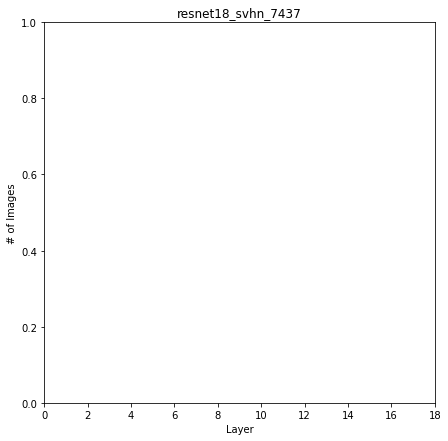

In [24]:
# plot PDs histogram
with open(os.path.join(save_dir,expt_name+'_testPDinfo.pkl'), 'rb') as handle:
    batch_info = pickle.load(handle)

batch_info['pd'] = np.array(batch_info['pd'])
batch_info['labels'] = np.array(batch_info['labels'])
batch_info['preds'] = np.array(batch_info['preds'])
correct_preds_arr = (batch_info['preds']==batch_info['labels'])


plt.figure(figsize=(7,7))
plt.title(expt_name)
plt.ylabel('# of Images')
plt.xlabel('Layer')
if model=='resnet18':
    plt.xlim((0,18))
elif model=='vgg16':
    plt.xlim((0,16))
# plt.ylim((0,80))
plt.hist(batch_info['pd'][correct_preds_arr ],bins=100,color='g',alpha=0.55)
# plt.hist(batch_info['pd'][~correct_preds_arr ],bins=100,color='r',alpha=0.55)
plt.savefig(os.path.join(save_dir,expt_name+'_PDplot.png'))

In [25]:
batch_info['pred_probs']

[0.9997909665107727,
 0.9929024577140808,
 0.9909534454345703,
 0.9991387128829956,
 0.9986586570739746,
 0.9876435995101929,
 0.9996235370635986,
 0.9931790828704834,
 0.9993667006492615,
 0.9989110231399536,
 0.9999932050704956,
 0.9864609241485596,
 0.9990491271018982,
 0.9977049231529236,
 0.9992374181747437,
 0.9998973608016968,
 0.9969248175621033,
 0.998752236366272,
 0.9489956498146057,
 0.9896492958068848,
 0.999805748462677,
 0.9978311657905579,
 0.9990193843841553,
 0.9819990396499634,
 0.4774087965488434,
 0.999976396560669,
 0.9999833106994629,
 0.9998514652252197,
 0.9989135265350342,
 0.9999936819076538,
 0.9999985694885254,
 0.9990562796592712,
 0.9995755553245544,
 0.9868789315223694,
 0.9995360374450684,
 0.9971376657485962,
 0.9733971357345581,
 0.9999446868896484,
 0.9997314810752869,
 0.9999206066131592,
 0.9996284246444702,
 0.998062789440155,
 0.9959035515785217,
 0.9997630715370178,
 0.9950915575027466,
 0.9940768480300903,
 0.9997761845588684,
 0.99999368190765

# Viz some Image

In [ ]:
T1 = transforms.ToPILImage()
T2 = transforms.Resize((256,256))
# img = train_subset[100][0]
img = testset.data[100]
T2(T1((img)))

# GradCAM on Intermediate Layers

### Option-1

In [ ]:
# using grad_cam_forward pass

In [ ]:
# load checkpoint
expt_name = 'vgg16_mnist_patch_34272'
net = nn.DataParallel(VGG('VGG16',num_channels=1))
net.load_state_dict(torch.load(os.path.join(save_dir,f'{expt_name}.pt'))['net'])
net.eval()
layer_id1 = 3 # vgg layer to viz net.module.features[layer_id1]
               # 0,3,7,10,14,17,20,24,27,30,34,37,40
layer_id2 = 1 # info_dict['feats'][layer_id2]
              # 0,1,2,3,4,5,6,7,8,9,10,11,12
img_id = 19

In [ ]:
# add hook to layer you want to viz    
feature_maps = []  # This will be a list of Tensors, each representing a feature map
def hook_feat_map(mod, inp, out):
    feature_maps.append(torch.reshape(out, (out.shape[0],-1)))
    
net.module.features[layer_id1].register_forward_hook(hook_feat_map)

In [ ]:
# get the nearest K neighbours
K = 29
lp_norm = 1
train_embs_pkl_path = os.path.join(save_dir,f'{expt_name}.pkl')

img = testset.data[img_id]
lab = testset.targets[img_id]

with torch.no_grad():
    # make img compatible for forward pass
    to_pil_trans = transforms.ToPILImage()
    if dataset=='mnist' or dataset=='kmnist' or dataset=='fmnist':
        img = to_pil_trans(img.to('cuda'))
    else:
        img = to_pil_trans(img.permute(2,0,1).to('cuda'))
    img = trans(img).unsqueeze(0)
    if img.shape[1]==4:
        img = img[:,0,:,:].unsqueeze(0)
        
    feature_maps = []
    out = torch.sigmoid(net(img))
    print(f'Model output: {out}')
    
    with open(train_embs_pkl_path, 'rb') as handle:            
        info_dict = pickle.load(handle)

        X_i = feature_maps[0].unsqueeze(1)  # (10000, 1, 784) test set
        X_j = info_dict['feats'][layer_id2].unsqueeze(0)  # (1, 60000, 784) train set
        if lp_norm==2:
            D_ij = ((X_i - X_j) ** 2).sum(-1)  # (10000, 60000) symbolic matrix of squared L2 distances
        elif lp_norm==1:
            D_ij = (abs(X_i - X_j)).sum(-1)  # (10000, 60000) symbolic matrix of squared L2 distances
        else:
            raise('Invalid lp_norm in arguments!')

        ind_knn = torch.topk(-D_ij,K,dim=1)  # Samples <-> Dataset, (N_test, K)
        lab_knn = info_dict['labels'][ind_knn[1]]  # (N_test, K) array of integers in [0,9]


    # free GPU memory
    del info_dict
    torch.cuda.empty_cache()

In [ ]:
nbr_inds = np.array(ind_knn[1][0].detach().cpu())
nbr_feats = X_j[0,nbr_inds,:].to('cuda')
nbr_labels = lab_knn.squeeze()
s = float(torch.median(-ind_knn[0]).detach().cpu()) # for the median trick


# pre-process the img to make it compatible for forward pass
to_pil_trans = transforms.ToPILImage()
if dataset=='mnist' or dataset=='kmnist' or dataset=='fmnist':
    img = to_pil_trans(img.squeeze().to('cuda'))
else:
    img = to_pil_trans(img.permute(2,0,1).to('cuda'))
img = trans(img).unsqueeze(0)
lab = int(lab)
if img.shape[1]==4:
    img = img[:,0,:,:].unsqueeze(0)
feature_maps = []
out, img_feat = net.module.gradcam_forward(img.to('cuda'),nbr_feats,nbr_labels,layer_id1,s)

# show intermediate gradcam
out.backward()

# pull the gradients out of the model
gradients = net.module.get_activations_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = img_feat.detach()

# weight the channels by corresponding gradients
for i in range(activations.shape[1]):
    activations[:, i, :, :] *= pooled_gradients[i]

# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze().detach().cpu()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= (torch.max(heatmap)+1e-10)

# draw the heatmap
plt.matshow(heatmap.squeeze())

In [ ]:
T1 = torchvision.transforms.Compose([
        torchvision.transforms.Resize((256,256)),
        torchvision.transforms.ToTensor(),
#         torchvision.transforms.Lambda(center_crop()),
        torchvision.transforms.Lambda(lambda x: x.repeat(3,1,1)),
    ])
img = testset.data[img_id]
img = T1(to_pil_trans(img.squeeze()))
   
T2 = torchvision.transforms.Compose([
        torchvision.transforms.ToPILImage(),
        torchvision.transforms.Resize((256,256)),
        torchvision.transforms.ToTensor(),
#         torchvision.transforms.Lambda(center_crop()),
    ])
heatmap = T2(heatmap)

xxx = cm.get_cmap('xxx')
heatmap2 = xxx(heatmap.squeeze())

img2 = torch.cat((img,1.0*torch.ones(256,256).unsqueeze(0)))
plt.figure(figsize=(10,10))
plt.imshow(1.0*img2.permute(1,2,0)+1.0*heatmap2)
# plt.imshow(1.2*img2.permute(1,2,0))

In [ ]:
# 0,3,7,10,14,17,20,24,27,30,34,37,40

### Option-2

In [ ]:
# visualizing the final output, but with different target layers

In [ ]:
# # load checkpoint
# img_id = 18
# img = testset.data[img_id]
# lab = testset.targets[img_id]
# expt_name = 'vgg16_kmnist_patch_48316'
# net = nn.DataParallel(VGG('VGG16',num_channels=1))
# net.load_state_dict(torch.load(os.path.join(save_dir,f'{expt_name}.pt'))['net'])
# net.eval()
# layer_id1 = -1 # vgg layer to viz net.module.features[layer_id1]
#                # 0,3,7,10,14,17,20,24,27,30,34,37,40
    


# # pre-process the img to make it compatible for forward pass
# to_pil_trans = transforms.ToPILImage()
# if dataset=='mnist' or dataset=='kmnist' or dataset=='fmnist':
#     img = to_pil_trans(img.squeeze().to('cuda'))
# else:
#     img = to_pil_trans(img.permute(2,0,1).to('cuda'))
# img = trans(img).unsqueeze(0)
# if img.shape[1]==4:
#     img = img[:,0,:,:].unsqueeze(0)
# feature_maps = []
# # out, img_feat = net.module.gradcam_forward(img.to('cuda'),nbr_feats,nbr_labels,layer_id1,s)
# out = net(img.to('cuda'))

# # compute grad cam masks
# targets = [ClassifierOutputTarget(0)]
# target_layers = [net.module.features[layer_id1]]

# # fetch Class Activation Maps (cams)
# cam = EigenCAM(model=net, target_layers=target_layers, use_cuda=True)
# grayscale_cams = cam(input_tensor=img, targets=targets, aug_smooth=True, eigen_smooth=True)

# # overlay cam on original images
# img = img.squeeze().unsqueeze(-1).detach().cpu().numpy()
# cam_op = show_cam_on_image(img, grayscale_cams[0]*0.5, use_rgb=True)
# img_list = []
# img_list.append(cam_op)

# # plot overlays
# plot_images(img_list,1,1)

In [ ]:
# user hyperparams
expt_name = 'vgg16_kmnist_patch_48316'
layer_id1 = 42

# load model
net = nn.DataParallel(VGG('VGG16',num_channels=1))
net.load_state_dict(torch.load(os.path.join(save_dir,f'{expt_name}.pt'))['net'])
net.eval()

# loop over test images
for _ in range(30):
    img_id = int(random.random()*len(testset.data))
    img = testset.data[img_id]
    
    # pre-process the img to make it compatible for forward pass
    to_pil_trans = transforms.ToPILImage()
    if dataset=='mnist' or dataset=='kmnist' or dataset=='fmnist':
        img_tensor = to_pil_trans(img.squeeze().to('cuda'))
    else:
        img_tensor = to_pil_trans(img.permute(2,0,1).to('cuda'))
    img_tensor = trans(img_tensor).unsqueeze(0)
    if img_tensor.shape[1]==4:
        img_tensor = img_tensor[:,0,:,:].unsqueeze(0)
        
    img_rgb = img_tensor.squeeze().unsqueeze(-1).expand(32,32,3)

    # gradCAM code
    targets = [ClassifierOutputTarget(0)]
    target_layers = [net.module.features[layer_id1]]

    cam = GradCAM(model=net, target_layers=target_layers, use_cuda=True)
    grayscale_cams = cam(input_tensor=img_tensor, targets=targets, aug_smooth=False, eigen_smooth=True)
    cam_op = show_cam_on_image(np.array(img_rgb), grayscale_cams[0], use_rgb=True)
    
    img_list = []
    img_list.append(img_rgb)
    img_list.append(grayscale_cams[0])
    img_list.append(cam_op)

    # plot results
    plot_images(img_list,rows=1,cols=3,titles=['Original Img','Heat Map','Overlay'])

### Option-3 SHAP (on final outputs)

In [ ]:
# user hyperparams
expt_name = 'vgg16_kmnist_27437'

# load model
net = nn.DataParallel(VGG('VGG16',num_channels=1))
net.load_state_dict(torch.load(os.path.join(save_dir,f'{expt_name}.pt'))['net'])
net.eval()

batch = next(iter(testloader))
images, _ = batch

shap_train_imgs = images[:10].to('cuda')
shap_test_imgs = images[10:14].to('cuda')

e = shap.DeepExplainer(net, shap_train_imgs)
shap_values = e.shap_values(shap_test_imgs)

shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(shap_test_imgs.cpu().numpy(), 1, -1), 1, 2)
shap.image_plot(shap_numpy, -test_numpy, width=100.0)

In [ ]:
net(shap_test_imgs).shape, len(shap_values), shap_values[0].shape

In [ ]:
for x in shap_train_imgs:
    print(x.unsqueeze(0).shape)

### Option-3 SHAP (on custom intermediate soft-KNN output)

In [ ]:
# user hyperparams
expt_name = 'vgg16_kmnist_27437'
layer_id = 0 # vgg layer to viz net.module.features[layer_id]
               # 0,3,7,10,14,17,20,24,27,30,34,37,40
train_emb_idx = 0 # info_dict['feats'][train_emb_idx]
              # 0,1,2,3,4,5,6,7,8,9,10,11,12

# load model
train_embs_pkl_path = os.path.join(save_dir,f'{expt_name}.pkl')
net = nn.DataParallel(customVGG2('VGG16', train_embs_pkl_path, layer_id, train_emb_idx, num_channels=1))
net.load_state_dict(torch.load(os.path.join(save_dir,f'{expt_name}.pt'))['net'])
net.eval()

# load batch of images
batch = next(iter(testloader))
images, _ = batch

# prepare shap train and test images
shap_train_imgs = images[:100].to('cuda')
shap_test_imgs = images[100:102].to('cuda')

e = shap.DeepExplainer(net, shap_train_imgs)
shap_values = e.shap_values(test_img)

shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_img.cpu().numpy(), 1, -1), 1, 2)
shap.image_plot(shap_numpy, -test_numpy, width=100.0)

### Option-4
Using grad-cam for intermediate layers as described in:
https://jacobgil.github.io/pytorch-gradcam-book/Pixel%20Attribution%20for%20embeddings.html

In [ ]:
# ===========user hyper-params==================
expt_name = 'vgg16_mnist_patch_34272'
net = nn.DataParallel(customVGG('VGG16',num_channels=1))
img_id = 5
layer_id1 = 0 # vgg layer to viz net.module.features[layer_id1]
               # 0,3,7,10,14,17,20,24,27,30,34,37,40
layer_id2 = 0 # info_dict['feats'][layer_id2]
              # 0,1,2,3,4,5,6,7,8,9,10,11,12
# =============================

In [ ]:
net.load_state_dict(torch.load(os.path.join(save_dir,f'{expt_name}.pt'))['net'])
net.eval()
# add hook to layer you want to viz    
feature_maps = []  # This will be a list of Tensors, each representing a feature map
def hook_feat_map(mod, inp, out):
    feature_maps.append(torch.reshape(out, (out.shape[0],-1)))
    
net.module.features[layer_id1].register_forward_hook(hook_feat_map)

# get the nearest K neighbours
K = 29
lp_norm = 1
train_embs_pkl_path = os.path.join(save_dir,f'{expt_name}.pkl')

img = testset.data[img_id]
lab = testset.targets[img_id]

with torch.no_grad():
    # make img compatible for forward pass
    to_pil_trans = transforms.ToPILImage()
    if dataset=='mnist' or dataset=='kmnist' or dataset=='fmnist':
        img = to_pil_trans(img.to('cuda'))
    else:
        img = to_pil_trans(img.permute(2,0,1).to('cuda'))
    img = trans(img).unsqueeze(0)
    if img.shape[1]==4:
        img = img[:,0,:,:].unsqueeze(0)
        
    feature_maps = []
    out = torch.sigmoid(net.module.simpleForward(img.to('cuda')))
    print(f'Model output: {out}')
    
    with open(train_embs_pkl_path, 'rb') as handle:            
        info_dict = pickle.load(handle)

        X_i = feature_maps[0].unsqueeze(1)  # (10000, 1, 784) test set
        X_j = info_dict['feats'][layer_id2].unsqueeze(0)  # (1, 60000, 784) train set
        if lp_norm==2:
            D_ij = ((X_i - X_j) ** 2).sum(-1)  # (10000, 60000) symbolic matrix of squared L2 distances
        elif lp_norm==1:
            D_ij = (abs(X_i - X_j)).sum(-1)  # (10000, 60000) symbolic matrix of squared L2 distances
        else:
            raise('Invalid lp_norm in arguments!')

        ind_knn = torch.topk(-D_ij,K,dim=1)  # Samples <-> Dataset, (N_test, K)
        lab_knn = info_dict['labels'][ind_knn[1]]  # (N_test, K) array of integers in [0,9]


    # free GPU memory
    del info_dict
    torch.cuda.empty_cache()

In [ ]:
nbr_inds = np.array(ind_knn[1][0].detach().cpu())
nbr_feats = X_j[0,nbr_inds,:].to('cuda')
nbr_labels = lab_knn.squeeze()
s = float(torch.median(-ind_knn[0]).detach().cpu()) # for the median trick

net.module.nbr_feats = nbr_feats
net.module.nbr_labels = nbr_labels
net.module.s = s
net.module.layer_id = layer_id1

In [ ]:
# pre-process the img to make it compatible for forward pass
to_pil_trans = transforms.ToPILImage()
if dataset=='mnist' or dataset=='kmnist' or dataset=='fmnist':
    img = to_pil_trans(img.squeeze().to('cuda'))
else:
    img = to_pil_trans(img.permute(2,0,1).to('cuda'))
img = trans(img).unsqueeze(0)
if img.shape[1]==4:
    img = img[:,0,:,:].unsqueeze(0)

# compute grad cam masks
targets = [ClassifierOutputTarget(0)]
target_layers = [net.module.features[layer_id1]]

# fetch Class Activation Maps (cams)
cam = GradCAMPlusPlus(model=net, target_layers=target_layers, use_cuda=True)
grayscale_cams = cam(input_tensor=img, targets=targets, aug_smooth=False, eigen_smooth=True)

# overlay cam on original images
img = img.squeeze().unsqueeze(-1).detach().cpu().numpy()
cam_op = show_cam_on_image(img, grayscale_cams[0], use_rgb=True)
img_list = []
img_list.append(img)
img_list.append(grayscale_cams[0])
img_list.append(cam_op)

# plot overlays
plot_images(img_list,rows=1,cols=3)

In [ ]:
# code in loop
expt_name = 'vgg16_mnist_patch_34272'
net = nn.DataParallel(customVGG('VGG16',num_channels=1))
net.load_state_dict(torch.load(os.path.join(save_dir,f'{expt_name}.pt'))['net'])
net.eval()
for _ in range(1000):
    # ===========user hyper-params==================
    img_id = int(random.random()*len(testset.data))
    layer_id1 = 40 # vgg layer to viz net.module.features[layer_id1]
                   # 0,3,7,10,14,17,20,24,27,30,34,37,40
    layer_id2 = 12 # info_dict['feats'][layer_id2]
                  # 0,1,2,3,4,5,6,7,8,9,10,11,12
    # =============================
    # add hook to layer you want to viz    
    feature_maps = []  # This will be a list of Tensors, each representing a feature map
    def hook_feat_map(mod, inp, out):
        feature_maps.append(torch.reshape(out, (out.shape[0],-1)))

    net.module.features[layer_id1].register_forward_hook(hook_feat_map)

    # get the nearest K neighbours
    K = 29
    lp_norm = 1
    train_embs_pkl_path = os.path.join(save_dir,f'{expt_name}.pkl')

    img = testset.data[img_id]
    lab = testset.targets[img_id]

    with torch.no_grad():
        # make img compatible for forward pass
        to_pil_trans = transforms.ToPILImage()
        if dataset=='mnist' or dataset=='kmnist' or dataset=='fmnist':
            img = to_pil_trans(img.to('cuda'))
        else:
            img = to_pil_trans(img.permute(2,0,1).to('cuda'))
        img = trans(img).unsqueeze(0)
        if img.shape[1]==4:
            img = img[:,0,:,:].unsqueeze(0)

        feature_maps = []
        out = torch.sigmoid(net.module.simpleForward(img.to('cuda')))
        print(f'Model output: {out}')

        with open(train_embs_pkl_path, 'rb') as handle:            
            info_dict = pickle.load(handle)

            X_i = feature_maps[0].unsqueeze(1)  # (10000, 1, 784) test set
            X_j = info_dict['feats'][layer_id2].unsqueeze(0)  # (1, 60000, 784) train set
            if lp_norm==2:
                D_ij = ((X_i - X_j) ** 2).sum(-1)  # (10000, 60000) symbolic matrix of squared L2 distances
            elif lp_norm==1:
                D_ij = (abs(X_i - X_j)).sum(-1)  # (10000, 60000) symbolic matrix of squared L2 distances
            else:
                raise('Invalid lp_norm in arguments!')

            ind_knn = torch.topk(-D_ij,K,dim=1)  # Samples <-> Dataset, (N_test, K)
            lab_knn = info_dict['labels'][ind_knn[1]]  # (N_test, K) array of integers in [0,9]


        # free GPU memory
        del info_dict
        torch.cuda.empty_cache()

    nbr_inds = np.array(ind_knn[1][0].detach().cpu())
    nbr_feats = X_j[0,nbr_inds,:].to('cuda')
    nbr_labels = lab_knn.squeeze()
    s = float(torch.median(-ind_knn[0]).detach().cpu()) # for the median trick

    net.module.nbr_feats = nbr_feats
    net.module.nbr_labels = nbr_labels
    net.module.s = s
    net.module.layer_id = layer_id1

    # pre-process the img to make it compatible for forward pass
    to_pil_trans = transforms.ToPILImage()
    if dataset=='mnist' or dataset=='kmnist' or dataset=='fmnist':
        img = to_pil_trans(img.squeeze().to('cuda'))
    else:
        img = to_pil_trans(img.permute(2,0,1).to('cuda'))
    img = trans(img).unsqueeze(0)
    if img.shape[1]==4:
        img = img[:,0,:,:].unsqueeze(0)

    # compute grad cam masks
    targets = [ClassifierOutputTarget(0)]
    target_layers = [net.module.features[layer_id1]]

    # fetch Class Activation Maps (cams)
    cam = GradCAMPlusPlus(model=net, target_layers=target_layers, use_cuda=True)
    grayscale_cams = cam(input_tensor=img, targets=targets, aug_smooth=False, eigen_smooth=True)

    # overlay cam on original images
    img = img.squeeze().unsqueeze(-1).detach().cpu().numpy()
    cam_op = show_cam_on_image(img, grayscale_cams[0], use_rgb=True)
    img_list = []
    img_list.append(img)
    img_list.append(grayscale_cams[0])
    img_list.append(cam_op)

    # plot overlays
    plot_images(img_list,rows=1,cols=3,titles=['Original Img','Heat Map','Overlay'])

# Re-Train Only Initial Layers on Randomized Labels

In [ ]:
# user hyperparams
expt_name = 'vgg16_kmnist_patch_48316'
num_ch = 1

In [ ]:
net = nn.DataParallel(VGG('VGG16',num_channels=num_ch))
net.load_state_dict(torch.load(os.path.join(save_dir,f'{expt_name}.pt'))['net'])
for i in range(10,45,1):
    for param in net.module.features[i].parameters():
        param.requires_grad = False
for param in net.module.classifier.parameters():
        param.requires_grad = False

In [ ]:
# sanity checking if all gradients false except initial layers
for param in net.module.parameters():
    print(param.requires_grad)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
net = net.to(device)
    
if device == 'cuda':
    cudnn.benchmark = True


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


# Training
def train(epoch, randomize_labels=False):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(tqdm(trainloader)):
        if randomize_labels:
            targets = targets[torch.randperm(targets.shape[0])] # randomize labels
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                 % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))


def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(testloader)):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    print(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                 % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))


In [ ]:
train(2,randomize_labels=True)
test(2)
scheduler.step()

print('Saving..')
state = {
    'net': net.state_dict(),
    'epoch': 2,
}
#         if not os.path.isdir(f'{args['expt_name']}_checkpoint'):
#             os.mkdir('checkpoint')
torch.save(state, os.path.join(save_dir,f'{expt_name}_a.pt'))

# Re-Train Only Final Layers on True Labels

In [ ]:
# freeze initial layers
for param in net.parameters():
    param.requires_grad = True

for i in range(0,10,1):
    for param in net.module.features[i].parameters():
        param.requires_grad = False

In [ ]:
# sanity checking if all gradients false except initial layers
for param in net.module.parameters():
    print(param.requires_grad)

In [ ]:
epoch = 3
train(epoch,randomize_labels=False)
test(epoch)
scheduler.step()

print('Saving..')
state = {
    'net': net.state_dict(),
    'epoch': epoch,
}
#         if not os.path.isdir(f'{args['expt_name']}_checkpoint'):
#             os.mkdir('checkpoint')
torch.save(state, os.path.join(save_dir,f'{expt_name}_b.pt'))

# Misc

In [ ]:
expt_name = 'vgg16_mnist_75872'

In [ ]:
# plot PDs histogram

with open(os.path.join(save_dir,expt_name+'_testPDinfo.pkl'), 'rb') as handle:
    batch_info = pickle.load(handle)

batch_info['pd'] = np.array(batch_info['pd'])
batch_info['labels'] = np.array(batch_info['labels'])
batch_info['preds'] = np.array(batch_info['preds'])
correct_preds_arr = (batch_info['preds']==batch_info['labels'])


plt.figure(figsize=(7,7))
plt.title('MNIST', fontsize=25)
plt.ylabel('No. of Images', fontsize=25)
plt.xlabel('VGG16 Layers', fontsize=25)
if model=='resnet18':
    plt.xlim((0,18))
elif model=='vgg16':
    plt.xlim((0,16))
plt.ylim((0,80))
plt.hist(batch_info['pd'][correct_preds_arr ],bins=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],color='g',alpha=0.55)
plt.hist(batch_info['pd'][~correct_preds_arr ],bins=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],color='r',alpha=0.55)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig(os.path.join(save_dir,expt_name+'_PDplot.png'))

In [ ]:
expt_name = 'vgg16_fmnist_88507'

In [ ]:
# plot PDs histogram

with open(os.path.join(save_dir,expt_name+'_testPDinfo.pkl'), 'rb') as handle:
    batch_info = pickle.load(handle)

batch_info['pd'] = np.array(batch_info['pd'])
batch_info['labels'] = np.array(batch_info['labels'])
batch_info['preds'] = np.array(batch_info['preds'])
correct_preds_arr = (batch_info['preds']==batch_info['labels'])


plt.figure(figsize=(7,7))
plt.title('FMNIST', fontsize=25)
plt.ylabel('No. of Images', fontsize=25)
plt.xlabel('VGG16 Layers', fontsize=25)
if model=='resnet18':
    plt.xlim((0,18))
elif model=='vgg16':
    plt.xlim((0,16))
plt.ylim((0,80))
plt.hist(batch_info['pd'][correct_preds_arr ],bins=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],color='g',alpha=0.55)
plt.hist(batch_info['pd'][~correct_preds_arr ],bins=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],color='r',alpha=0.55)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig(os.path.join(save_dir,expt_name+'_PDplot.png'))

In [ ]:
expt_name = 'vgg16_cifar10_18394'

In [ ]:
# plot PDs histogram

with open(os.path.join(save_dir,expt_name+'_testPDinfo.pkl'), 'rb') as handle:
    batch_info = pickle.load(handle)

batch_info['pd'] = np.array(batch_info['pd'])
batch_info['labels'] = np.array(batch_info['labels'])
batch_info['preds'] = np.array(batch_info['preds'])
correct_preds_arr = (batch_info['preds']==batch_info['labels'])


plt.figure(figsize=(7,7))
plt.title('CIFAR10', fontsize=25)
plt.ylabel('No. of Images', fontsize=25)
plt.xlabel('VGG16 Layers', fontsize=25)
if model=='resnet18':
    plt.xlim((0,18))
elif model=='vgg16':
    plt.xlim((0,16))
plt.ylim((0,80))
plt.hist(batch_info['pd'],bins=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],color='g',alpha=0.55)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig(os.path.join(save_dir,expt_name+'_PDplot.png'))

In [ ]:
expt_name = 'vgg16_kmnist_27437'

In [ ]:
# plot PDs histogram

with open(os.path.join(save_dir,expt_name+'_testPDinfo.pkl'), 'rb') as handle:
    batch_info = pickle.load(handle)

batch_info['pd'] = np.array(batch_info['pd'])
batch_info['labels'] = np.array(batch_info['labels'])
batch_info['preds'] = np.array(batch_info['preds'])
correct_preds_arr = (batch_info['preds']==batch_info['labels'])


plt.figure(figsize=(7,7))
plt.title('KMNIST w/o patch', fontsize=25)
plt.ylabel('No. of Images', fontsize=25)
plt.xlabel('VGG16 Layers', fontsize=25)
if model=='resnet18':
    plt.xlim((0,18))
elif model=='vgg16':
    plt.xlim((0,16))
plt.ylim((0,80))
plt.hist(batch_info['pd'][correct_preds_arr ],bins=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],color='g',alpha=0.55)
plt.hist(batch_info['pd'][~correct_preds_arr ],bins=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],color='r',alpha=0.55)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig(os.path.join(save_dir,expt_name+'_PDplot.png'))

In [ ]:
df = pd.read_csv('/xxx/home/xxx/xxx/xxx/projects/shortcut_detection_and_mitigation/data/mimic/full/train.csv')
df[df['pneumothorax']==0]

In [ ]:
212023/7977

In [ ]:
# loop over test images
invalid_counter = 0 # for invalid predictions (last layer mode != model output)
loader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=4)
for test_id, (img,lab) in enumerate(tqdm(loader)):

    batch_info['imgs'].append(img)
    img, lab = img.to(device), lab.to(device)
    with torch.no_grad():
        # lab = int(lab)
        feature_maps = []
        out = net(img)
        print(f'OUT = {out}')
        print(f'Model output: {out.max()}')
        batch_info['preds'].append(int(out.argmax()))
        batch_info['pred_probs'].append(float(torch.nn.functional.softmax(out).max()))
        batch_info['labels'].append(lab)

        print_memory_profile('Model forward pass')
        with open(train_embs_pkl_path, 'rb') as handle:            
            info_dict = pickle.load(handle)
            print_memory_profile('Pickle load')

            # loop over layers in densenet, and compute KNN for this test image
            knn_preds_mode = []  # layer-wise final KNN classification preds   
            knn_preds_prob = []
            for layer_id,feat in tqdm(enumerate(feature_maps)):
                X_i = feat.unsqueeze(1)  # (10000, 1, 784) test set
                X_j = info_dict['feats'][layer_id].unsqueeze(0)  # (1, 60000, 784) train set
                if lp_norm==2:
                    D_ij = ((X_i - X_j) ** 2).sum(-1)  # (10000, 60000) symbolic matrix of squared L2 distances
                elif lp_norm==1:
                    D_ij = (abs(X_i - X_j)).sum(-1)  # (10000, 60000) symbolic matrix of squared L2 distances
                else:
                    raise('Invalid lp_norm in arguments!')

                ind_knn = torch.topk(-D_ij,K,dim=1)  # Samples <-> Dataset, (N_test, K)
                lab_knn = info_dict['labels'][ind_knn[1]]  # (N_test, K) array of integers in [0,9]
#                 print(f'!!!!!!test_img:{test_id}, nbrs in layer {layer_id}: {ind_knn[1]}')
                mode = int(lab_knn.squeeze().mode()[0])
                knn_preds_mode.append(mode)
                knn_preds_prob.append(float((lab_knn==mode).float().mean()))

            print_memory_profile('Pickle batch processed')

            # free GPU memory
            del info_dict
            torch.cuda.empty_cache()
            print_memory_profile('After GPU memory freed') 

            print('Test Image: %d' %(test_id))
            print(f'knn_preds_mode: {knn_preds_mode}')
            print(f'knn_preds_prob: {knn_preds_prob}')
            print(f'label: {lab}')
            print(f'pred: {int(out.argmax())}')
            print('\n')
            batch_info['layers_knn_prob'].append(knn_preds_prob)
            batch_info['layers_knn_mode'].append(knn_preds_mode)
            if int(out.argmax())==knn_preds_mode[-1]: # PD accurate
                if knn_pos_thresh==0.5 and knn_neg_thresh==0.5:
                    batch_info['pd'].append(compute_pred_depth(knn_preds_mode))
                else:
                    raise('Code not ready yet! Compute pred arr function also has to be updated!')
            else: # PD inaccurate, KNN pred doesn't match model pred
                print('Invalid datapoint: last_layer_mode != model_output')
                invalid_counter += 1
                batch_info['pd'].append(-99)
print(f'Invalid Counts Ratio: {invalid_counter}/{num_test_imgs}')